# Some Tools of Financial Modeling

This notebook contains some basic tools of financial modeling.  It is sparse with respect to references and discussion of the relevant literature.  This can be found elsewhere.   

These modeling tools are essentially diffusion models.  

In [1]:
# Load the libraries.

%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt 
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#import Quandl
from IPython.display import Image
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import pymc3 as pm
import theano

## The Capital Asset Pricing Model (CAPM)

When I teach applied data science, I use CAPM as an example of the bivariate linear regression model.  (Admittedly, this follows from the canonical Berndt book.)  I use it for a reason: absent experimental data, it is the only application of the bivariate linear model that I believe has validity in the real world.  CAPM remains one of the workhorse statistical models in finance.  It is so common that sites like Yahoo!Finance report the measures we will estimate statistically.  

Based on CAPM, we can directly interpret the intercept and slope coefficients of the bivariate model as real-world measures relating the excess (or risk-adjusted) returns of a particular stock to those of a basket of stocks, such as the market on which the stock trades.

Let $r_i$ denote the rate of return to asset $i$, $r_f$ denote the known rate of return on a risk-free asset (for example, short-term US government debt), and $r_m$ denote the rate of return to a portfolio (or a market) that includes $i$.  

The following equation can be derived:

$E(r_i)-r_f = \alpha + \beta \cdot (E(r_m)-r_f)$

Here, $E(\cdot)$ denotes an expected value (because this is a forward-looking prediction).  In CAPM, $\beta$ captures the sensitivity of an asset’s returns to the returns to a portfolio or to the market on which an asset trades.  In other words, it's non-diversifiable risk.  In addition, $\alpha$ measures an asset $i$’s excess (or abnormal) returns.

Phrases you may have heard: 

1. The stock's beta is high
2. The hedge fund is chasing alpha

Formally, we can express our conjecture as a joint hypothesis (assuming informational efficiency):

$H_0: \alpha = 0, \beta=1$

$H_1: \text{ not }H_0$

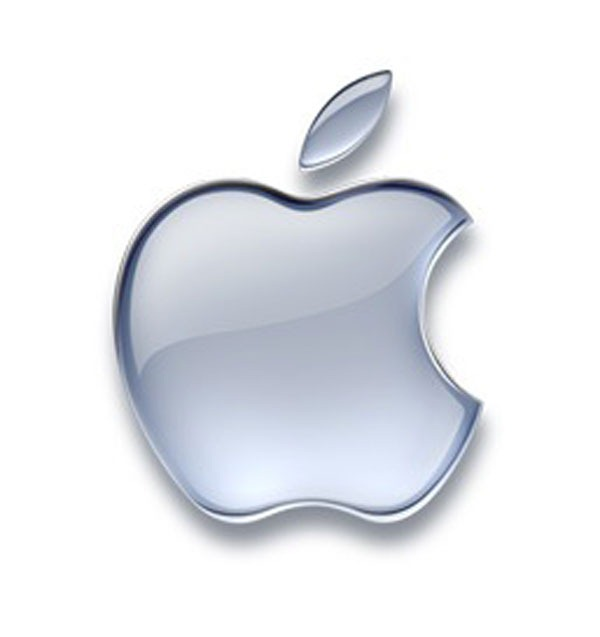

In [2]:
from IPython.display import Image
url = 'http://buzzmybiz.co/wp-content/uploads/2012/06/apple-logo.jpg'
Image(url, width=400, height=400)

In [3]:
start, end = dt.datetime(2006, 1, 1), dt.datetime(2017, 12, 31)
aapl_all = web.DataReader('aapl', 'yahoo', start, end)
nasdaq_all = web.DataReader('^ixic', 'yahoo', start, end)
aapl = aapl_all['Adj Close']
nasdaq = nasdaq_all['Adj Close']

Text(0.5, 1.0, '2006 - 2017')

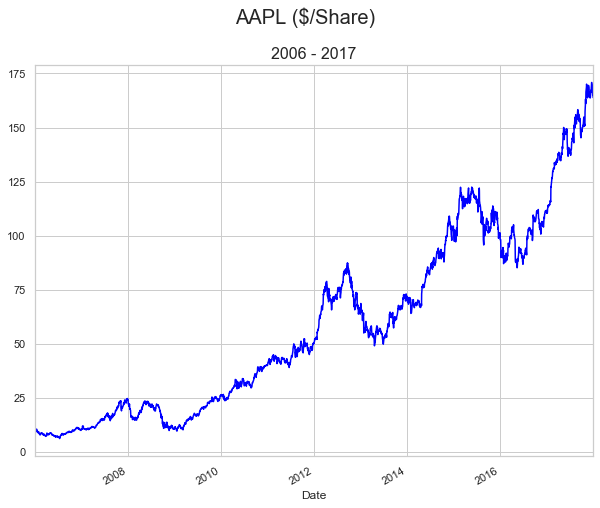

In [4]:
plt.figure(figsize=(10, 8))
aapl.plot(color='blue')
plt.suptitle('AAPL ($/Share)', fontsize=20)
plt.title('2006 - 2017', fontsize=16)

Text(0.5, 1.0, '2006 - 2017')

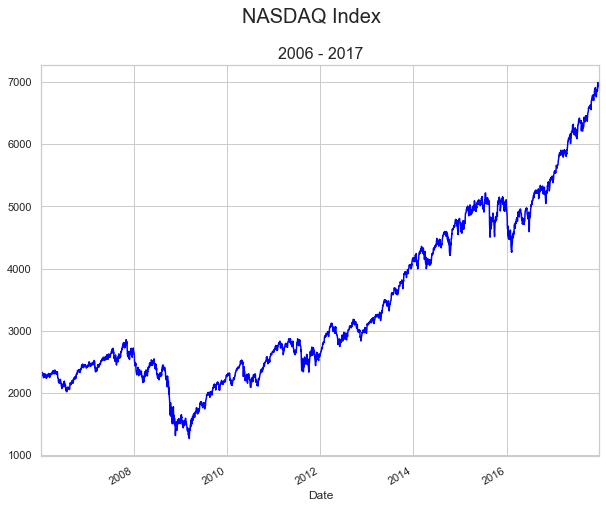

In [5]:
plt.figure(figsize = (10, 8))
nasdaq.plot(color='blue')
plt.suptitle('NASDAQ Index', fontsize=20)
plt.title('2006 - 2017', fontsize=16)

In [6]:
# Calculate log returns.
# Display mean and volatility.
# Note the differences: AAPL has on average higher daily returns and more volatility.

aapl_returns = ((np.log(aapl / aapl.shift(1))).dropna())
nasdaq_returns = (np.log(nasdaq / nasdaq.shift(1))).dropna()

print (aapl_returns.mean(), aapl_returns.std())
print (nasdaq_returns.mean(), nasdaq_returns.std())

0.0009514246373007009 0.020436214372954113
0.00037226515503065014 0.013162834158993235


(0, 60)

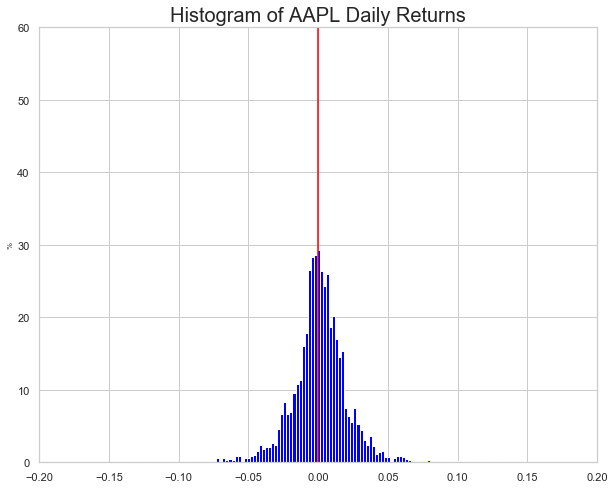

In [7]:
# Display histogram of AAPL returns.
# Do they look normally distributed?

plt.figure(figsize=(10, 8))
plt.hist(aapl_returns, bins=150, normed=True, color='blue')
plt.title('Histogram of AAPL Daily Returns', fontsize=20)
plt.ylabel('%', fontsize=8)
plt.axvline(0, color='red')
plt.xlim(-0.2, 0.2)
plt.ylim(0, 60)

(0, 60)

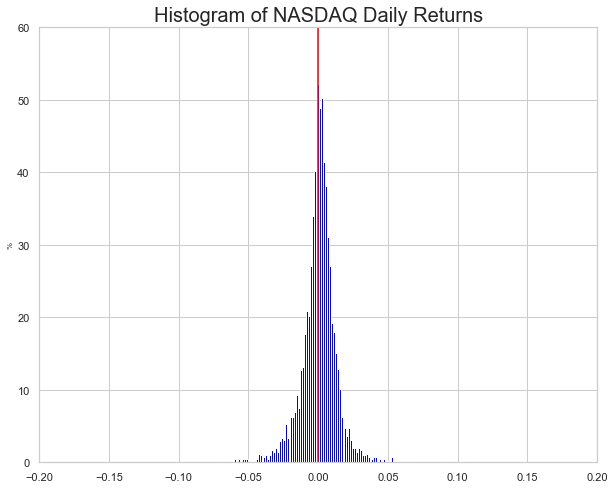

In [8]:
plt.figure(figsize=(10, 8))
plt.hist(nasdaq_returns, bins=150, normed=True, color='blue')
plt.title('Histogram of NASDAQ Daily Returns', fontsize=20)
plt.ylabel('%', fontsize=8)
plt.axvline(0, color='red')
plt.xlim(-0.2, 0.2)
plt.ylim(0, 60)

In [9]:
aapl_returns = pd.DataFrame(aapl_returns)
nasdaq_returns = pd.DataFrame(nasdaq_returns)

(-0.1, 0.1)

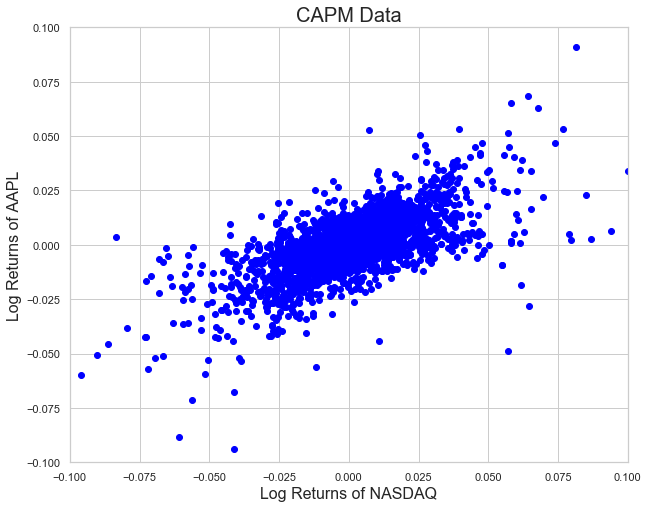

In [10]:
plt.figure(figsize = (10, 8))
plt.scatter(aapl_returns, nasdaq_returns, color='blue')
plt.title('CAPM Data', fontsize = 20)
plt.xlabel('Log Returns of NASDAQ', fontsize = 16)
plt.ylabel('Log Returns of AAPL', fontsize = 16)
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])

In [11]:
aapl_r = pd.DataFrame(aapl_returns)
nasdaq_r = pd.DataFrame(nasdaq_returns)
data = pd.merge(nasdaq_r, aapl_r, left_index=True, right_index=True)
data.head()
data.rename(columns={'Adj Close_x':'nasdaq', 'Adj Close_y':'aapl'}, inplace=True)
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     2309.
Date:                Sun, 08 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:13:11   Log-Likelihood:                 8319.9
No. Observations:                3019   AIC:                        -1.664e+04
Df Residuals:                    3017   BIC:                        -1.662e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006      0.000      2.038      0.0

(-0.1, 0.1)

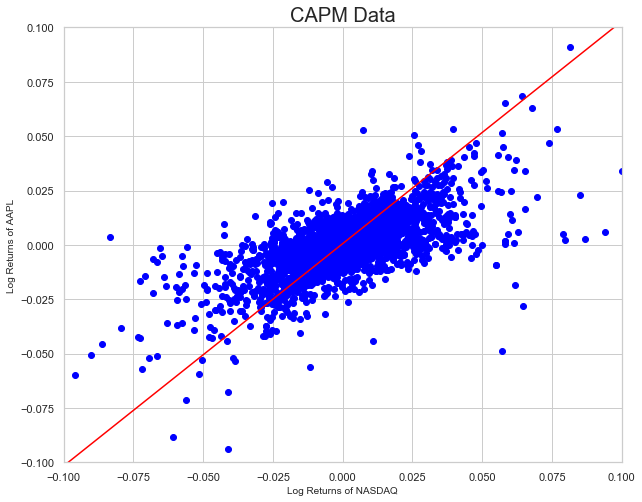

In [12]:
figure, ax = plt.subplots(figsize=(10, 8))
ax.scatter(aapl_returns, nasdaq_returns, color='blue')
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
abline_plot(model_results=mod, ax=ax, color='red')

ax.set_title('CAPM Data', fontsize = 20)
ax.set_ylabel('Log Returns of AAPL', fontsize = 10)
ax.set_xlabel('Log Returns of NASDAQ', fontsize = 10)
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])

In [13]:
print(mod.f_test("Intercept = 0"))
print(mod.f_test("nasdaq = 1"))
print(mod.f_test("nasdaq = 1, Intercept = 0"))

<F test: F=array([[4.15408829]]), p=0.04162116981674677, df_denom=3.02e+03, df_num=1>
<F test: F=array([[1.09692351]]), p=0.29502615385032155, df_denom=3.02e+03, df_num=1>
<F test: F=array([[2.68801184]]), p=0.068178925086599, df_denom=3.02e+03, df_num=2>


### A Bayesian Approach to CAPM

The frequestist approach to CAPM does not allow us directly to address interesting hypotheses, such as:

What's the probability that $\alpha>0$?

What't the probability that $\beta<1$?

What's the joint probability that $(\alpha>0, \beta<1)$?

In [14]:
with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta * nasdaq_returns
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=aapl_returns)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = 8,300.9, ||grad|| = 3,115.4: 100%|██████████| 27/27 [00:00<00:00, 646.10it/s]         
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 289.55draws/s]


<Figure size 720x720 with 0 Axes>

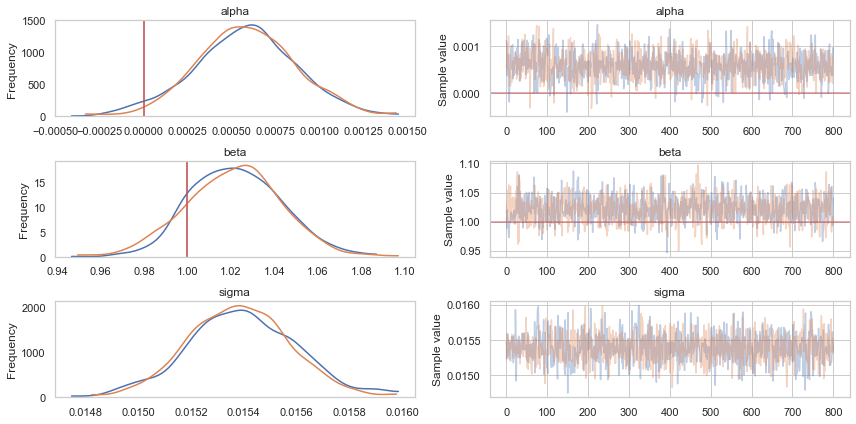

<Figure size 720x720 with 0 Axes>

In [15]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace[199:1000], lines={'alpha': 0, 'beta': 1})
plt.figure(figsize = (10, 10))

This is a strength of the Bayesian approach.  Using transparent prior beliefs, combined with real-world data, we have simulated the posterior distribution functions of two quantities of interest.

In [16]:
# Having simulated the entire posterior probability distributions, 
# we can calculate useful metrics.

# Start with averages and 95% credible intervals.
# Note their simularity to the least squares results.

print("The probability that alpha is greater than zero is %f" % np.mean(trace['alpha'][199:1000] > 0.0))
print("The probability that beta is less than one is %f" % np.mean(trace['beta'][199:1000] < 1.0))
print("The joint probability is %f" % np.all([[trace['alpha'][199:1000] > 0.0], [trace['beta'][199:1000] < 1.0]], axis = 0).mean())
print()
print(mod.summary())

The probability that alpha is greater than zero is 0.965044
The probability that beta is less than one is 0.137328
The joint probability is 0.132335

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     2309.
Date:                Sun, 08 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:13:44   Log-Likelihood:                 8319.9
No. Observations:                3019   AIC:                        -1.664e+04
Df Residuals:                    3017   BIC:                        -1.662e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      

## Common Dynamic Stochastic Models of Spot Interest Rates

Like stock prices, future random paths of interest rates can be modeled using the stochastic calculus of Ito's Lemma and no arbitrage conditions.  Here are some examples.  There are no citations, as ample material is available.  For example, one could start with the Wikipedia pages on stochastic calculus, the Black-Scholes-Merton model of options pricing, and Weiner (or Brownian motion) processes.

Text(0.5, 0.98, '10-Year U.S. Treasuries')

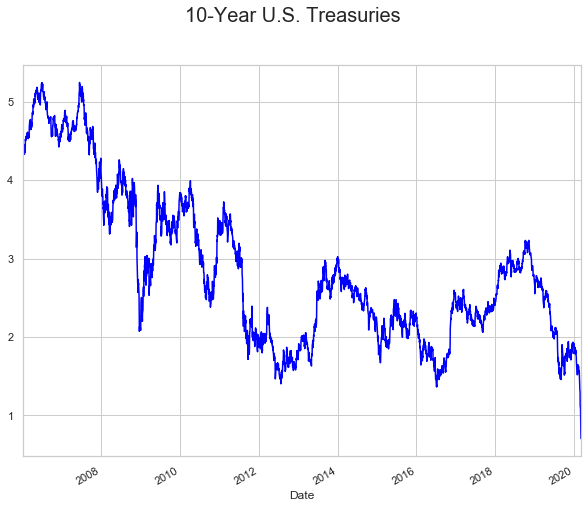

In [17]:
# Suppose one wanted to model 10-year US Treasurys.  (Yes, the spelling is correct.)  Start with observed rates.

start = dt.datetime(2006, 1, 1)
rates = web.DataReader('^TNX', 'yahoo', start)

plt.figure(figsize=(10, 8))
rates['Adj Close'].plot(color='blue')
plt.suptitle('10-Year U.S. Treasuries', fontsize=20)

In [18]:
# Calculate average and standard deviation (as a measure of volatility).

mean = rates['Adj Close'].mean() 
vol = rates['Adj Close'].std() 
print(rates['Adj Close'].mean(), rates['Adj Close'].std())

2.8595506191186235 0.9814856759013106


### The Vasicek Model

Let $r(t)$ denote a short-term interest rate at time t, which varies continuously, and $dr(t)$ denote the time path of $r(t)$.  The Vasicek model focuses on a common financial concept of mean reversion, namely that interest rates fluctuate at random around some "natural" (perhaps Wicksellian) rate of interest.  

$dr(t) = \kappa (\theta − r(t))dt + \sigma dW(t)$

In this model, $\theta$ is the natural rate, $\kappa$ is the speed with which random deviations from the natural rate dissapate, and $\sigma$ is the inherent volatility of associated with random deviations captured in the Weiner process, $dW(t)$.

In [19]:
def v(r0, kappa, theta, sigma, Time, N, randomseed):
    np.random.seed(randomseed)
    dt = float(Time / N)
    rates = [r0]
    for i in range(N):
        dr = kappa * (theta - rates[-1]) * dt + sigma * np.random.normal()
        rates.append(rates[-1] + dr) 
    return range(N+1), rates

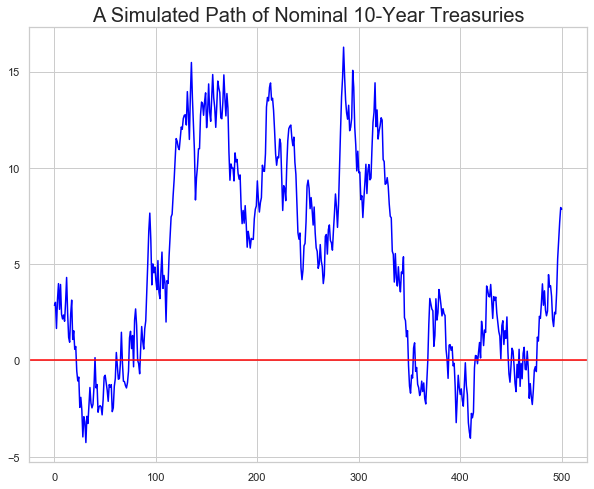

In [20]:
# Use Vasicek model with observed data.  
# We see there's an immediate problem: negative nominal interest ratees.
# This used to be a quaint binding constraint.

x, y = v(mean, 0.30, mean, vol, 10., 500, 382020)

plt.figure(figsize=(10, 8))
plt.plot(x, y, color='blue')
plt.axhline(0, color='red')
plt.title('A Simulated Path of Nominal 10-Year Treasuries', fontsize=20)
plt.show()

### The Cox-Ingersoll-Ross (CIR) Model

To account for the zero lower bound (ZLB) on nominal rates, the CIR model includes a dampening term that affects the volatility of the random shock.  As rates go to zero, volatility goes to zero which, depending on the value of $\kappa$, should force the rate to converge rapidly back to the natural rate.  (NB: This model embeds the quaint notion that nominal rates cannot go negative.  As a result, the model is undefinied when r(t) < 0.

$dr(t) = \kappa (\theta − r(t))dt + \sigma \sqrt{r(t)} dW(t)$

In [21]:
def cir(r0, kappa, theta, sigma, Time, N, randomseed):
    np.random.seed(randomseed)
    dt = float(Time / N)
    rates = [r0]
    for i in range(N):
        dr = kappa * (theta - rates[-1]) * dt + sigma * np.sqrt(np.absolute(rates[-1])) * np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

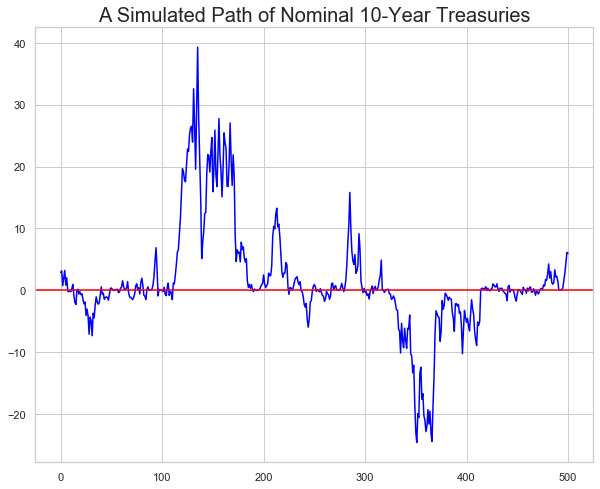

In [22]:
x, y = cir(mean, 0.30, mean, vol, 10., 500, 382020)

plt.figure(figsize=(10, 8))
plt.plot(x, y, color='blue')
plt.axhline(0, color='red')
plt.title('A Simulated Path of Nominal 10-Year Treasuries', fontsize=20)
plt.show()

### The Dothan Model

This is simply geometric Brownian motion with a positive drift.  (NB: The primary driver in this model is $\alpha$.  This representation is continuous-time version of the discrete-time AR(1) model.)  

$dr(t) = \alpha r(t) dt + \sigma r(t) dW(t)$

In [23]:
def d(r0, alpha, sigma, Time, N, randomseed):
    np.random.seed(randomseed)
    dt = float (Time / N)
    rates = [r0]
    for i in range(N):
        dr = alpha * rates[-1] * dt + sigma * rates[-1] * np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

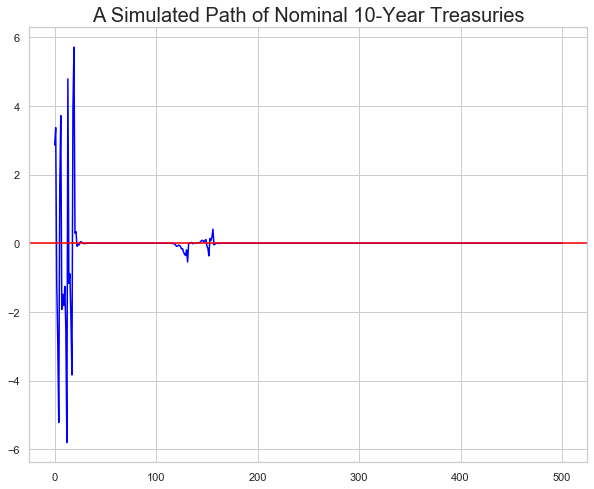

In [24]:
x, y = d(mean, 0.95, vol, 10, 500, 382020)

plt.figure(figsize=(10, 8))
plt.plot(x, y, color='blue')
plt.axhline(0, color='red')
plt.title('A Simulated Path of Nominal 10-Year Treasuries', fontsize=20)
plt.show()

## The Rendleman-Barrter (RB) Model

The Rendleman-Barrter model is identical to the geometric Brownian motion model for asset prices.  For this model, there is no mean reversion, and deviations from some natural (or Wicksillian) rate of interest has no meaning.  In this model, evolution is proportional to the level of rates and random shocks.  As we are modeling nominal rates of interest, this model might be appropriate for periods of hyperinflation.  It is not clear that it is appropriate for modeling interest rates under standard macroeconomic conditions and especially since the GFC.

$dr(t) = \theta r(t)dt + \sigma {r(t)} dW(t)$

In [25]:
def rb(r0, theta, sigma, Time, N, randomseed):
    np.random.seed(randomseed)
    dt = float(Time / N)
    rates = [r0]
    for i in range(N):
        dr = theta * rates[-1] * dt + sigma * rates[-1] * np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

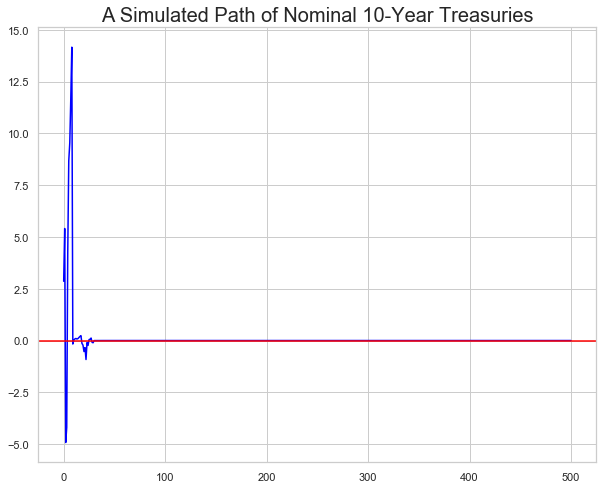

In [26]:
# The return of Volcker.

x, y = rb(mean, 0.01, vol, 10., 500, 1066)

plt.figure(figsize=(10, 8))
plt.plot(x, y, color='blue')
plt.axhline(0, color='red')
plt.title('A Simulated Path of Nominal 10-Year Treasuries', fontsize=20)
plt.show()

## The Brennan-Schwartz (BS) Model

The Brennan-Schwartz model is a variation on the theme of the CIR. 

$dr(t) = \kappa (\theta − r(t))dt + \sigma r(t) dW(t)$

In [27]:
def bs(r0, kappa, theta, sigma, Time, N, randomseed):
    np.random.seed(randomseed)
    dt = float (Time / N)
    rates = [r0]
    for i in range(N):
        dr = kappa * (theta - rates[-1]) * dt + sigma * rates[-1] * np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

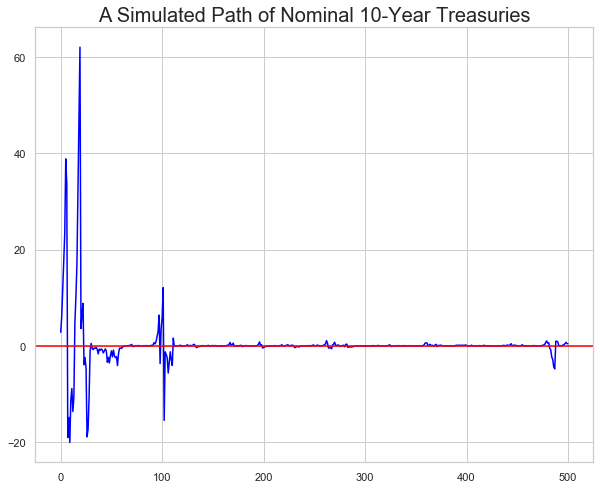

In [28]:
x, y = bs(mean, 0.30, mean, vol, 10., 500, 10241929)

plt.figure(figsize=(10, 8))
plt.plot(x, y, color='blue')
plt.axhline(0, color='red')
plt.title('A Simulated Path of Nominal 10-Year Treasuries', fontsize=20)
plt.show()

## The Exponential Vasicek Model

Another variation on a theme.
    
$dr(t) = r(t)(\eta - \alpha \ln{r(t)}) dt + \sigma r(t) dW(t)$     

In [29]:
def ev(r0, eta, alpha, sigma, Time, N, randomseed):
    np.random.seed(randomseed)
    dt = float (Time / N)
    rates = [r0]
    for i in range(N):
        dr = rates[-1] * (eta - alpha * np.log(rates[-1])) * dt + sigma * rates[-1] * np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

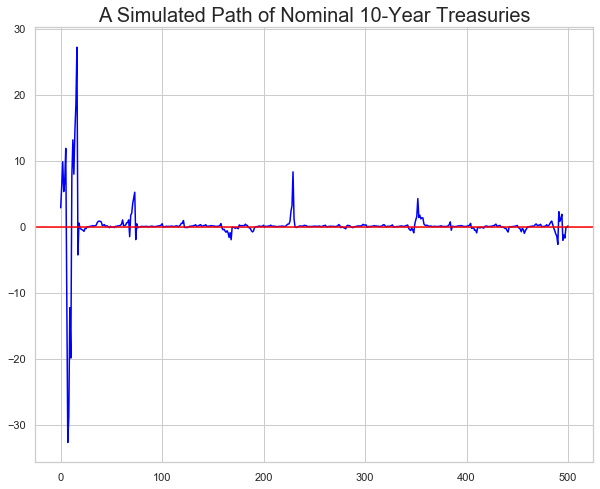

In [30]:
x, y = bs(mean, 0.350, mean, vol, 10., 500, 9152008)

plt.figure(figsize=(10, 8))
plt.plot(x, y, color='blue')
plt.axhline(0, color='red')
plt.title('A Simulated Path of Nominal 10-Year Treasuries', fontsize=20)
plt.show()